В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=False)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=False)

train_dataloader =  DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
valid_dataloader =  DataLoader(train_dataset, batch_size=12, shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [3]:
class Identical(nn.Module):
    def forward(self, x):
        return x

- В парадигме Sequential внутри можно использовать только блоки из nn. В чем разница: например, при модульном подходе F.ELU - это функция, которую мы применяем внутри метода forward, в случае Sequential мы используем nn.ELU - что является классом слоя и это добавляется в наш конструктор класса nn.Sequential

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


- В torch в разных модулях есть разные кросс-энтропии - одни принимают логиты, а другие принимают выходы softmax(logits), поэтому надо быть внимательнее, когда думаю ставить softmax на выходе forward или в Sequential слой -- надо немного подумать, потому что два раза если применять softmax, то можно получить очень плохой результат. (https://stackoverflow.com/questions/55030217/shall-i-apply-softmax-before-cross-entropy)

```python
nn.CrossEntropyLoss() - принимает логиты на вход, там внутри softmax есть

```

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
activation = nn.ELU
# нам надо 2 скрытых слоя, то есть: (сколько функций активации - столько скрытых слоев), скрытые слои - то, что отличает нашу сетку от обычной лог регрессии, у лог рега
# вход сразу коннектится к выходным логитам: nn.Linear(input, output) - весь логрег, короче да, надо просто схемку рисовать на листочке или в голове представлять.
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10)
).to(device)

In [25]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)>

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [27]:
# Блок для объяснений для меня:

for i in {'A': 1, 'B': 2}.items():
    print(type(i))

# как запомнить какое dimension есть какое - 0 dimension у нас всегда есть - это по колонкам, dimension 1 есть у матрицы и выше,
# dimension работает как для координатных осей: dim=0 - для оси x, dim=1 - для оси y, а когда много осей, то можно мыслить как shape в обратную сторону
# shape выдает размеры в том порядке, в каком мы разыменовываем: [k][j][i] <=> size(k, j, i)

print(torch.tensor(
    [[1, 2, 3],
    [4, 6, 5]]
).argmax(dim=-1))

(torch.tensor([1, 2, 3]) == torch.tensor([1, 2, 1])).sum().item()

<class 'tuple'>
<class 'tuple'>
tensor([2, 1])


2

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [28]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()   # переводим модель в режим обучения
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))

            preds = outp.argmax(dim=-1)     # из матрицы с batch_size штук строк, в каждой строке по 10 логитов - надо получить индекс максимального логита
                                            # dim=-1: смотрим по последнему измерению максимум - по каждой строке
            correct = (preds.cpu() == y_batch).sum()
            all = len(x_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.91255
Loader: valid. Accuracy: 0.9534333333333334
Epoch: 2
Loader: train. Accuracy: 0.9557666666666667
Loader: valid. Accuracy: 0.9644
Epoch: 3
Loader: train. Accuracy: 0.9649
Loader: valid. Accuracy: 0.9676
Epoch: 4
Loader: train. Accuracy: 0.9695666666666667
Loader: valid. Accuracy: 0.9740166666666666
Epoch: 5
Loader: train. Accuracy: 0.9725166666666667
Loader: valid. Accuracy: 0.9751
Epoch: 6
Loader: train. Accuracy: 0.9755
Loader: valid. Accuracy: 0.9760333333333333
Epoch: 7
Loader: train. Accuracy: 0.9772333333333333
Loader: valid. Accuracy: 0.9838333333333333
Epoch: 8
Loader: train. Accuracy: 0.979
Loader: valid. Accuracy: 0.9854833333333334
Epoch: 9
Loader: train. Accuracy: 0.9796
Loader: valid. Accuracy: 0.9847166666666667
Epoch: 10
Loader: train. Accuracy: 0.98075
Loader: valid. Accuracy: 0.9865333333333334


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9534333333333334,
 0.9644,
 0.9676,
 0.9740166666666666,
 0.9751,
 0.9760333333333333,
 0.9838333333333333,
 0.9854833333333334,
 0.9847166666666667,
 0.9865333333333334]

In [21]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation, max_epochs=10):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())        # это тоже надо заново объвялять тут внутри, потому что град спуск зависит от функции активации тожеs

    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            # делается сначала одна эпоха на трейне с обучением, а потом "эпоха" валидации
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()   # переводим модель в режим обучения
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))

                preds = outp.argmax(-1)
                correct =  (preds.flatten().cpu() == y_batch).sum()# YOUR CODE GOES HERE
                all =  len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

- У меня batch_size = 12, а у всех кого я проверял: 128, поэтому у меня точность отличается

у меня не в том месте accuracy стояла, поэтому так сильно была задрана точность.

In [22]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

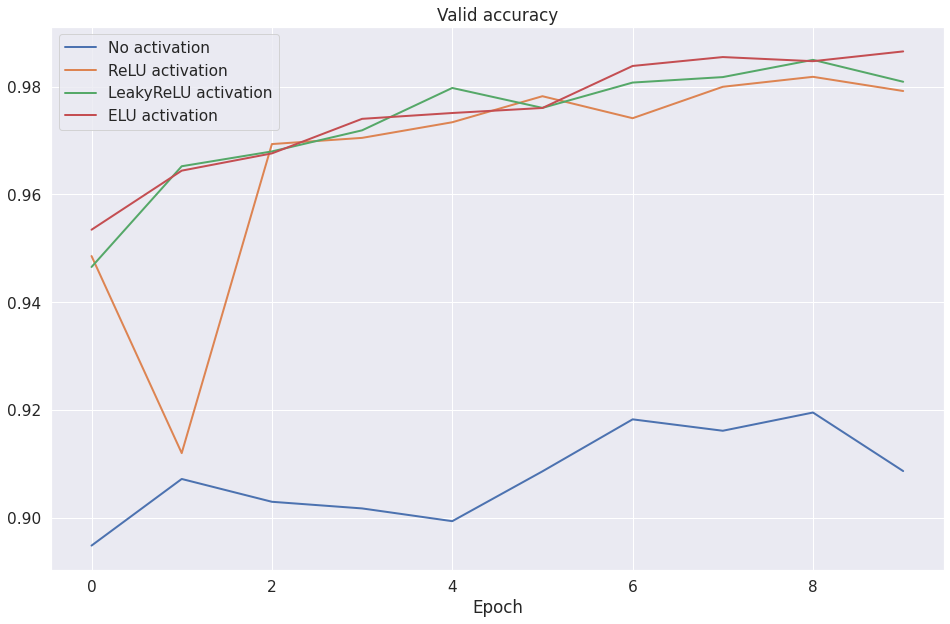

In [30]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

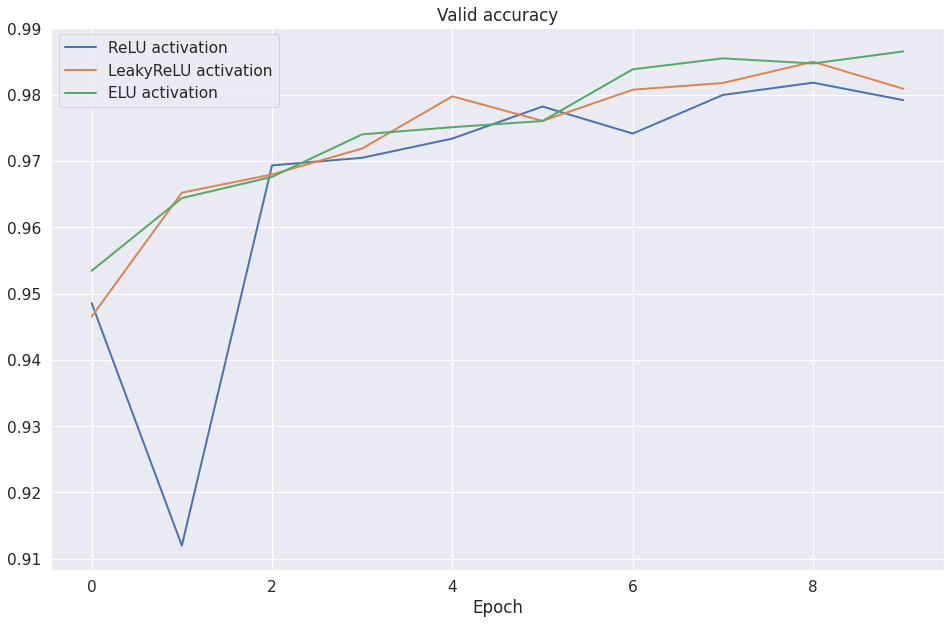

In [31]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
{
'elu': elu_accuracy[-1],
'plain': plain_accuracy[-1],
'relu': relu_accuracy[-1],
'leaky_relu': leaky_relu_accuracy[-1]
}

{'elu': 0.9856166666666667,
 'plain': 0.9927333333333334,
 'relu': 0.9931,
 'leaky_relu': 0.9832}

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ReLU показала наивысший accuracy к концу обучения: 0.9931** 

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-03-30 20:54:00--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-03-30 20:54:00--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    in 0,1s    

2022-03-30 20:54:01 (492 KB/s) - ‘sample_photo.jpg’ saved [49337/4

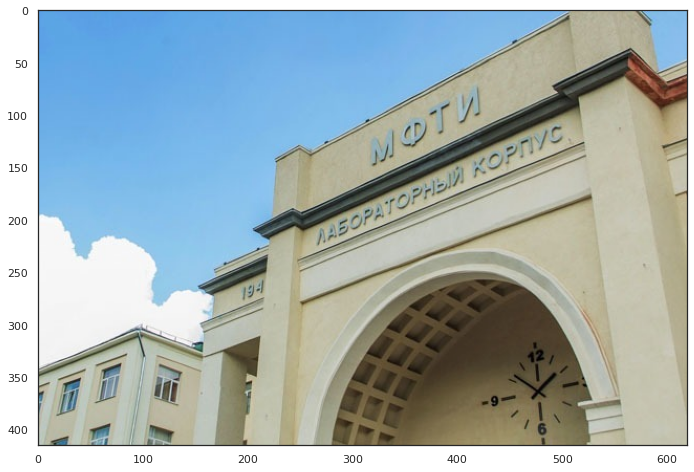

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

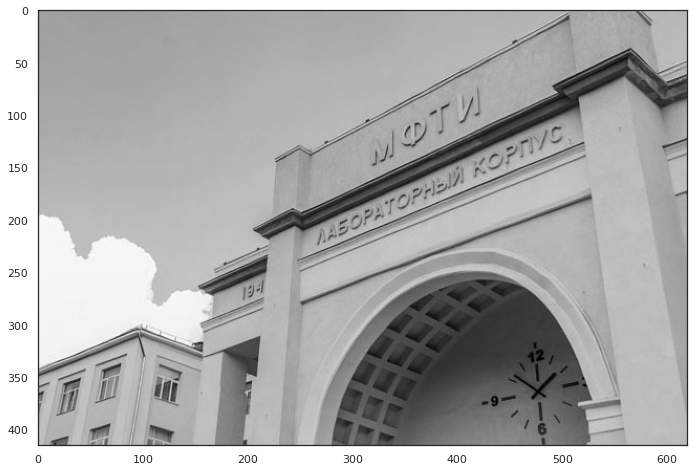

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

**Ответ:**

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ  - Б

6) Выделение границ - Г


### Задание. Реализуйте LeNet

По поводу 2д свертки многоканального изображения (в основном все пишут, что для многоканального изображения уже 3д свертку юзать удобнее): https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

Как раз на примере: пусть входит 6 карт, а на выходе 16 карт. Как это происходит:
- Для этого применяется 16 ядер для каждого канала (которые обучаются)
  
- Происходит следующее: для 1 канала применяем 1 ядро, предназначенное для этого канала, для 2 канала применяем 1 ядро для 2 канала, для 3 делаем то же самое, в итоге получаем 3 новые карты, которые суммируем и получаем первую карту из 16 для выхода. Так проделываем со всеми 16 ядрами для каждого канала и получаем 16 карт активации на выходе
  
- Очевидно, что это эквивалентно 3д свертке, количество обучаемых параметров здесь ровно такое же

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.

https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch - about .view

In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   # если будет плохое качество, то stride=1 сделаю
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)    # need to check an input size!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        # print(X.shape)
        X = X.view(-1, 16 * 5 * 5)      # вместо этого можно кстати юзать отдельный слой: self.flatten = nn.Flatten() и потом X = self.flatten(X)
        # print(X.shape)  # получили 12 строк из 400 элементов
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)     # здесь уже логиты просто выдаем
        
        return X

In [33]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
batch = next(iter(train_dataloader))

model.forward(torch.FloatTensor(batch[0]).cuda())
None
# Произведение 3 последний значений - размер входного изображения в FC слои

Обучим саму сетку:

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [34]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        # сначала проходимся по батчу обучающего датасета, потом по батчу валидационного
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()   # переводим модель в режим обучения
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))

            preds = outp.argmax(dim=-1)     # из матрицы с batch_size штук строк, в каждой строке по 10 логитов - надо получить индекс максимального логита
                                            # dim=-1: смотрим по последнему измерению максимум - по каждой строке
            correct = (preds.cpu() == y_batch).sum()
            all = len(x_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9414166666666667
Loader: valid. Accuracy: 0.9826666666666667
Epoch: 2
Loader: train. Accuracy: 0.9805
Loader: valid. Accuracy: 0.9888166666666667
Epoch: 3
Loader: train. Accuracy: 0.9860333333333333
Loader: valid. Accuracy: 0.9895833333333334


KeyboardInterrupt: 

In [ ]:
lenet_accuracy = accuracy["valid"]

In [ ]:
accuracy["valid"][-1]

0.9958

Сравним с предыдущем пунктом

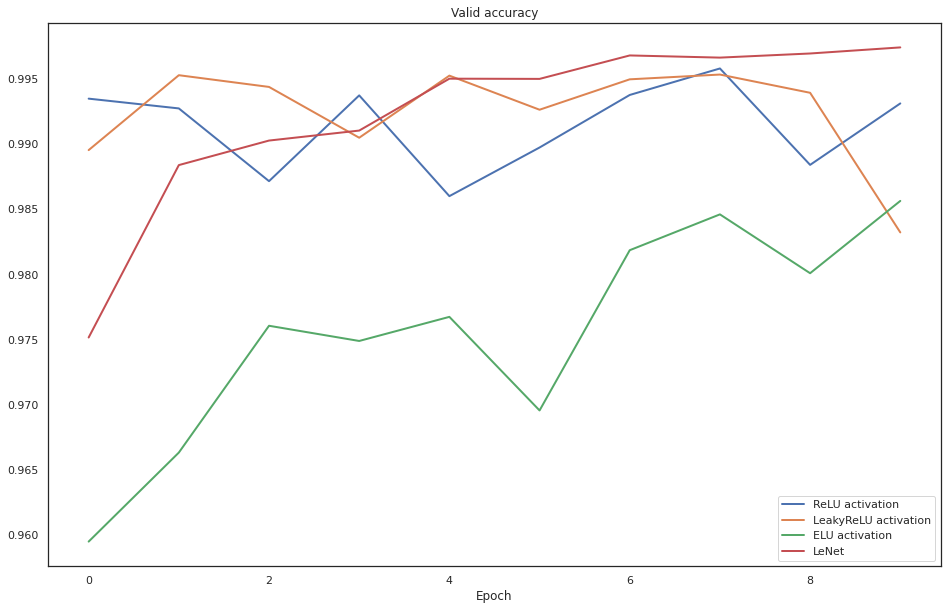

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: 99.74%**